In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from mpl_toolkits.axes_grid1 import make_axes_locatable
import geopandas as gpd
from scipy.signal import find_peaks

First lets see what the waste in the city looks like as a function of borough. For this we will recent df from 2024 thats available on the tonnage collected. 

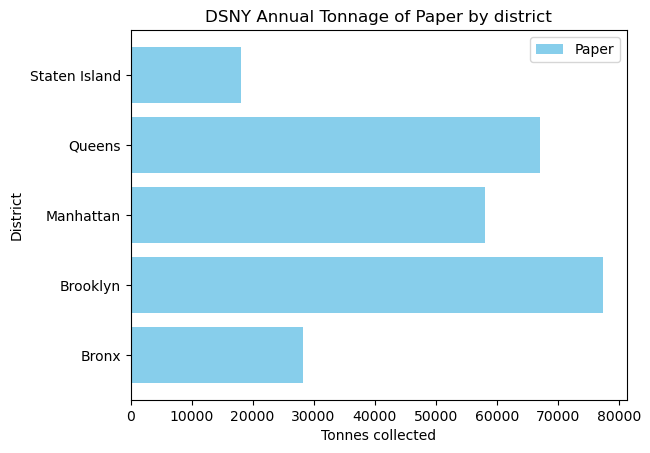

In [16]:
df=pd.read_csv("datas/DSNY_Monthly_Tonnage_df_20241227.csv")
df['MONTH'] = pd.to_datetime(df['MONTH'], format='%Y / %m')

# Filter rows where the year is 2024 or later
df_filtered = df[df['MONTH'].dt.year >= 2024]

# Display the filtered dfFrame
df_filtered

new_df=pd.dfFrame({"Zone":df_filtered["BOROUGH"],"Paper":df_filtered["PAPERTONSCOLLECTED"],"MGP":df_filtered["MGPTONSCOLLECTED"],"Refuse":df_filtered["REFUSETONSCOLLECTED"]})
new_df["Zone_ordinal"]=new_df.Zone.astype("category").cat.codes

summary = new_df.groupby('Zone_ordinal')[['Paper', 'MGP','Refuse']].sum().reset_index()

Zones= summary["Zone_ordinal"].tolist()
Paper = summary["Paper"].tolist()
MGP = summary["MGP"].tolist()
new_labels=["Bronx","Brooklyn","Manhattan","Queens","Staten Island"]
plt.barh(Zones,Paper,color="skyblue",label="Paper")
plt.yticks([0,1,2,3,4], new_labels) 
plt.xlabel("Tonnes collected")
plt.ylabel("District")
plt.title("DSNY Annual Tonnage of Paper by district")
plt.legend()
#plt.savefig("stacked_bar_chart_paper_tonnes_nyc.png", dpi=300, bbox_inches='tight') 

Below is the plot for Paper, Metal/Glass/plastic and refuse --which includes all the trash. 

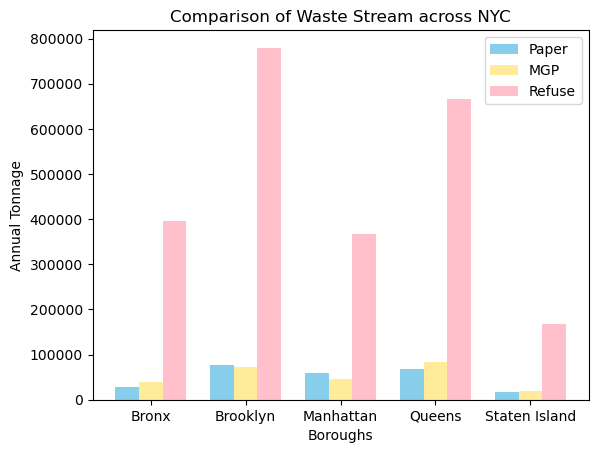

In [17]:
Zones= summary["Zone_ordinal"].tolist()
Refuse = summary["Refuse"].tolist()
Paper = summary["Paper"].tolist()
MGP = summary["MGP"].tolist()
boroughs=["Bronx","Brooklyn","Manhattan","Queens","Staten Island"]

bar_width = 0.25
positions = np.arange(len(new_labels))

# Plotting Bars
plt.bar(positions, Paper, color='skyblue', width=bar_width, label='Paper')
plt.bar(positions + bar_width, MGP, color='#ffeb99', width=bar_width, label='MGP')
plt.bar(positions + 2 * bar_width, Refuse, color='pink', width=bar_width, label='Refuse')

# Labels and Title
plt.xlabel('Boroughs')
plt.ylabel('Annual Tonnage')
plt.title('Comparison of Waste Stream across NYC')
plt.xticks(positions + bar_width, boroughs)
plt.legend()
plt.savefig("Waste_Stream_NYC.png", bbox_inches='tight')
# Show Plot
plt.show()

We can see that the trash in Brooklyn is the highest followed by Queens, Bronx, manhattan and then SI. One could imagine that comes from the population. 

For this lets load the df that shows the population from the 2020 census along with recyling and infrastuructre df from 2019. 

In [31]:
df_demo=pd.read_csv("datas/DemographicsTable.csv")
df=df_demo=pd.read_csv("datas/DemographicsTable.csv")
df_demo.info()
gdf = gpd.read_file("datas/NYC_Community_District_Tabulation_Areas_2020_769164889669816788.geojson")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 34 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   District                                      59 non-null     object 
 1   Organic Tons                                  59 non-null     float64
 2   MGP tons                                      59 non-null     float64
 3   Paper Tons                                    59 non-null     float64
 4   Refuse Tons                                   59 non-null     float64
 5   Diversion rate (%)                            59 non-null     float64
 6   Total Population                              59 non-null     int64  
 7   Median Age                                    59 non-null     float64
 8   Population/acre                               59 non-null     float64
 9   Hispanic                                      59 non-null     float

Furthermore, we will also load the map of NYC so that we may place the df ontop of it and visualize. 

In [33]:
df["District"] = df["District"].astype(str)
df["Total Population"].iloc[57] = 141050
df["Total Population"]
gdf["CDTA2020"] = gdf["CDTA2020"].astype(str)
merged_df = df.merge(gdf, left_on="District", right_on="CDTA2020", how="left")
merged_gdf = gpd.GeodfFrame(merged_df, geometry="geometry")

/var/folders/x8/hv6lnsx5209d4m84b842j095n23ctf/T/ipykernel_4154/2451681071.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df["Total Population"].iloc[57] = 141050
/var/folders/x8/hv6lnsx5209d4m84b842j095n23ctf/T/ipykernel_4154/245168107

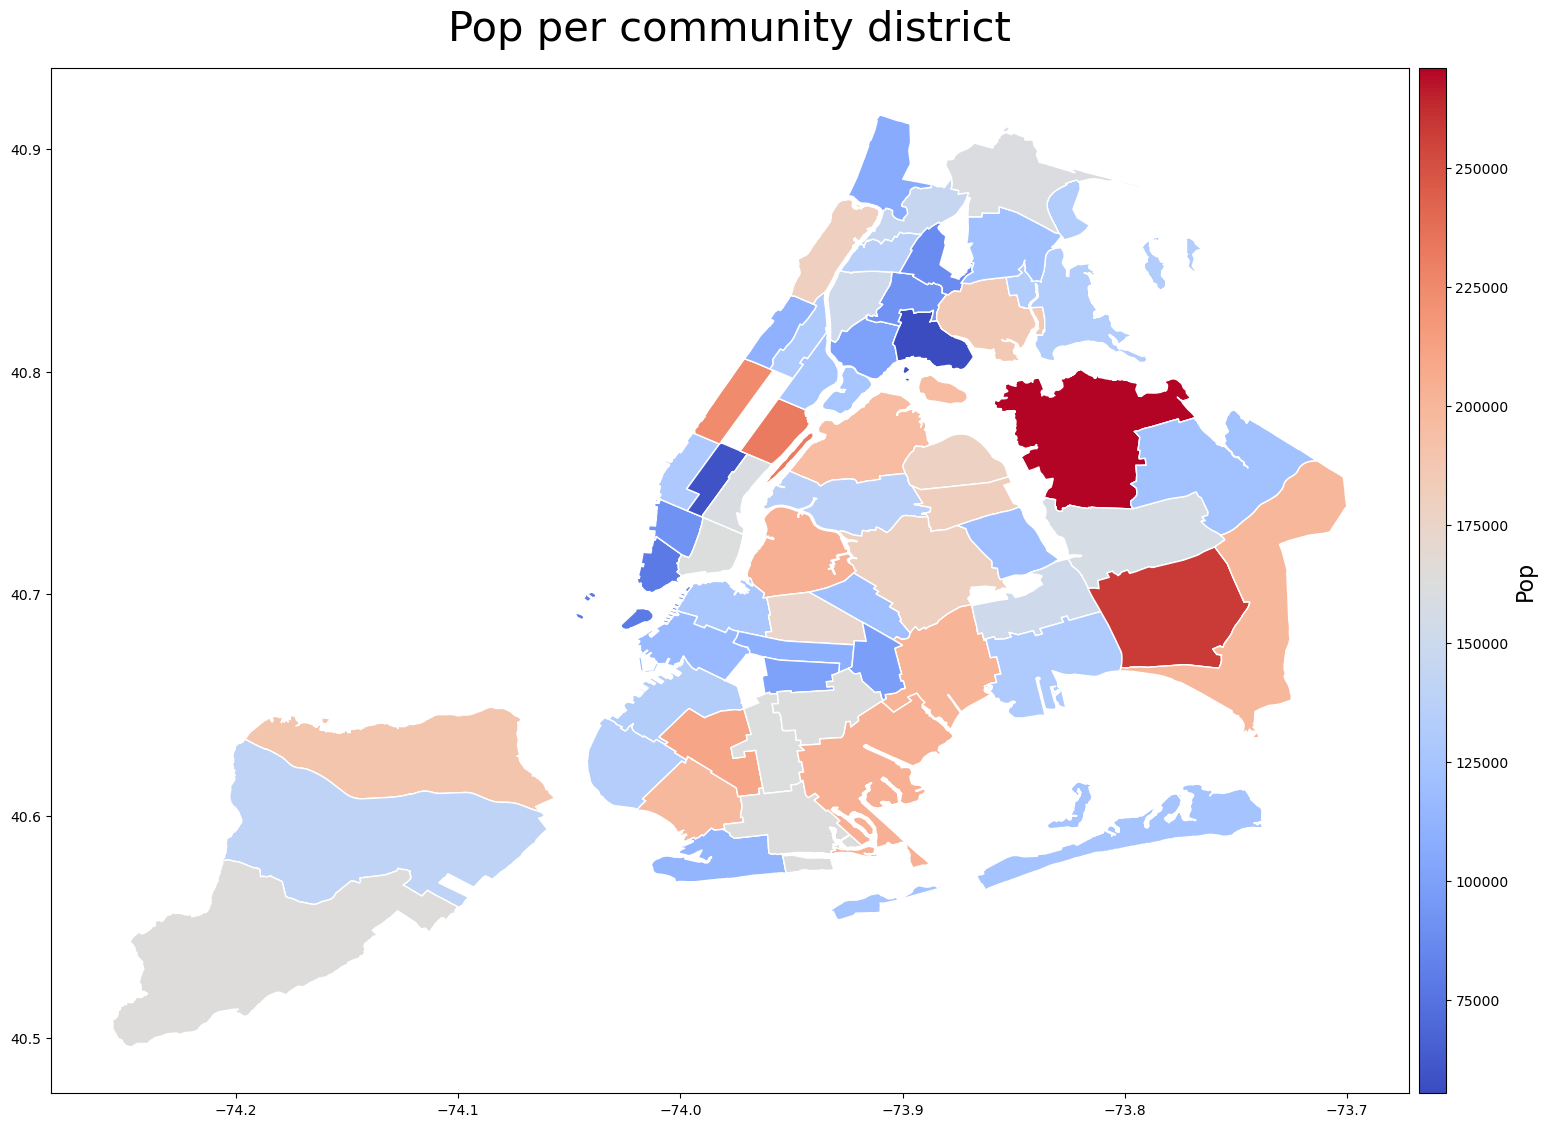

In [34]:
# Create figure with portrait dimensions
fig, ax = plt.subplots(figsize=(18, 26))

# Plot the map without the legend first and get the mappable object for the colorbar
mappable = merged_gdf.plot(
    column="Total Population", 
    cmap="coolwarm", 
    legend=False,  # No legend initially
    edgecolor="white",
    ax=ax
)

mappable = ax.get_children()[0]  # This should be the PathCollection with the colormap

# Keep the map's natural aspect ratio
ax.set_aspect('equal')

# Create a divider for the existing axes to place colorbar
divider = make_axes_locatable(ax)

# Append axes to the right of the main axes, with 2% width of the main axes
cax = divider.append_axes("right", size="2%", pad=0.1)

# Create colorbar in the appended axes
cbar = plt.colorbar(mappable, cax=cax)
cbar.set_label("Pop", size=16)

# Add title with padding
ax.set_title("Pop per community district", fontsize=30, pad=20)

# Save with tight bbox
plt.show()

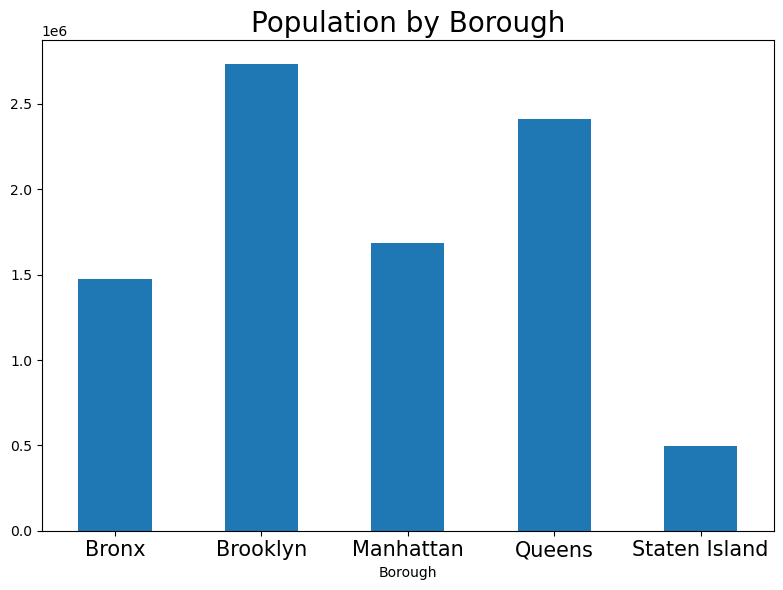

In [86]:
df['Borough'] = df['District'].str[:2].map({
    'BX': 'Bronx',
    'BK': 'Brooklyn', 
    'MN': 'Manhattan',
    'QN': 'Queens',
    'SI': 'Staten Island'
})

# Group by borough and plot
borough_pop = df.groupby('Borough')['Total Population'].sum()
borough_pop.plot(kind='bar', figsize=(8, 6))
plt.title('Population by Borough',fontsize=20)
plt.xticks(rotation=0,fontsize=15)
plt.tight_layout()
plt.savefig("pop_district.png")
plt.show()

This is interesting because despite manhattan having a higher population, Bronx is generating more trash. We know that the median income in Manhattan is higher than the ret of the city. Lets see if there's any effects on the public recyling infrastruture...To do so we can check the publicly accesible recyling bins per borough. 

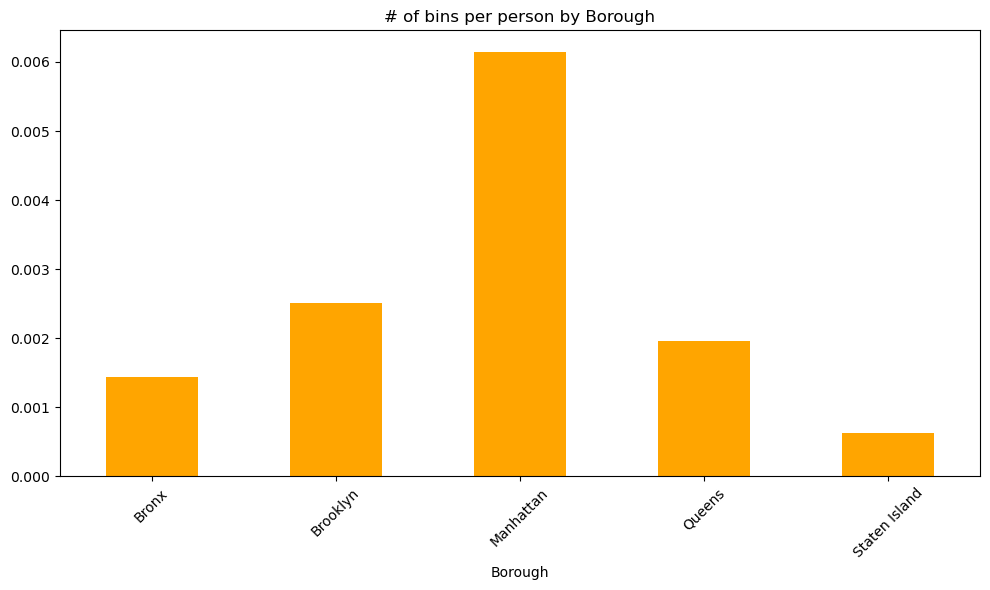

In [45]:
borough_bins = df.groupby('Borough')['Paper bins per person'].sum()
borough_bins.plot(kind='bar', figsize=(10, 6),color="orange")
plt.title('# of bins per person by Borough')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Manhattan on average seems to have more publicly accessible bins.

<Figure size 1800x1400 with 0 Axes>

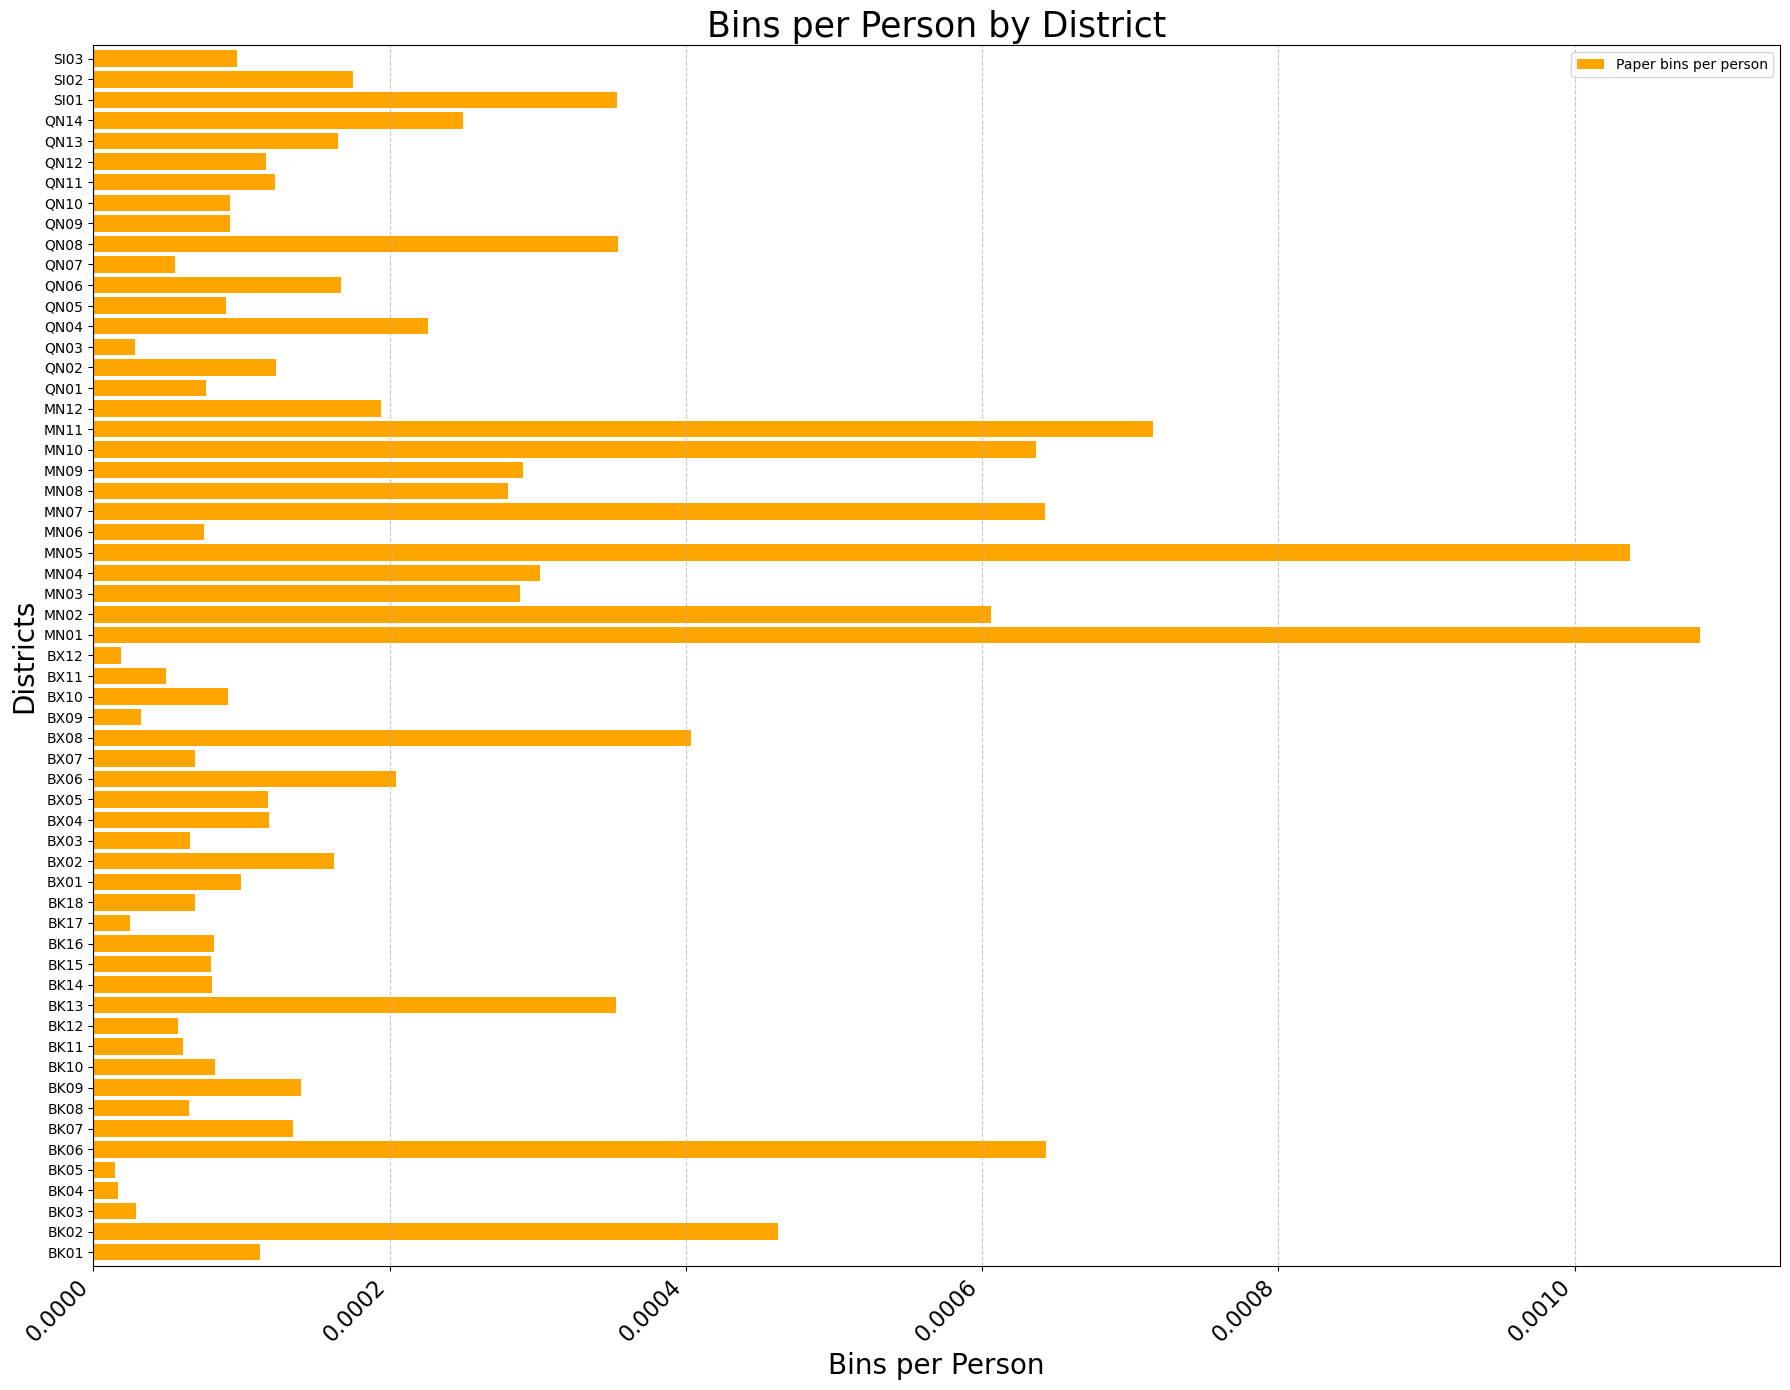

In [48]:
plt.figure(figsize=(18, 14))  # Further increased size of the chart

# Plot the bar chart with increased bar thickness and pastel colors
ax = df.groupby('District')[['Paper bins per person']].sum().plot(
    kind='barh', 
    stacked=True, 
    width=0.8,  # Thinner bars
    figsize=(18, 14),  # Increase figure size for better space
    color="orange"  # Apply pastel colors
)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=16)

# Add titles and labels
plt.title('Bins per Person by District', fontsize=25)
plt.ylabel('Districts', fontsize=20)
plt.xlabel('Bins per Person', fontsize=20)

# Optional: Add gridlines for easier reading of bar values
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()  # Ensure everything fits nicely
plt.savefig('Bins_by_district_per_person.png')
plt.show()

But does publicly accessible bins mean that people are recylign mroe as well? For this first lets see how the city performs in terms of recyling

<Figure size 1800x1400 with 0 Axes>

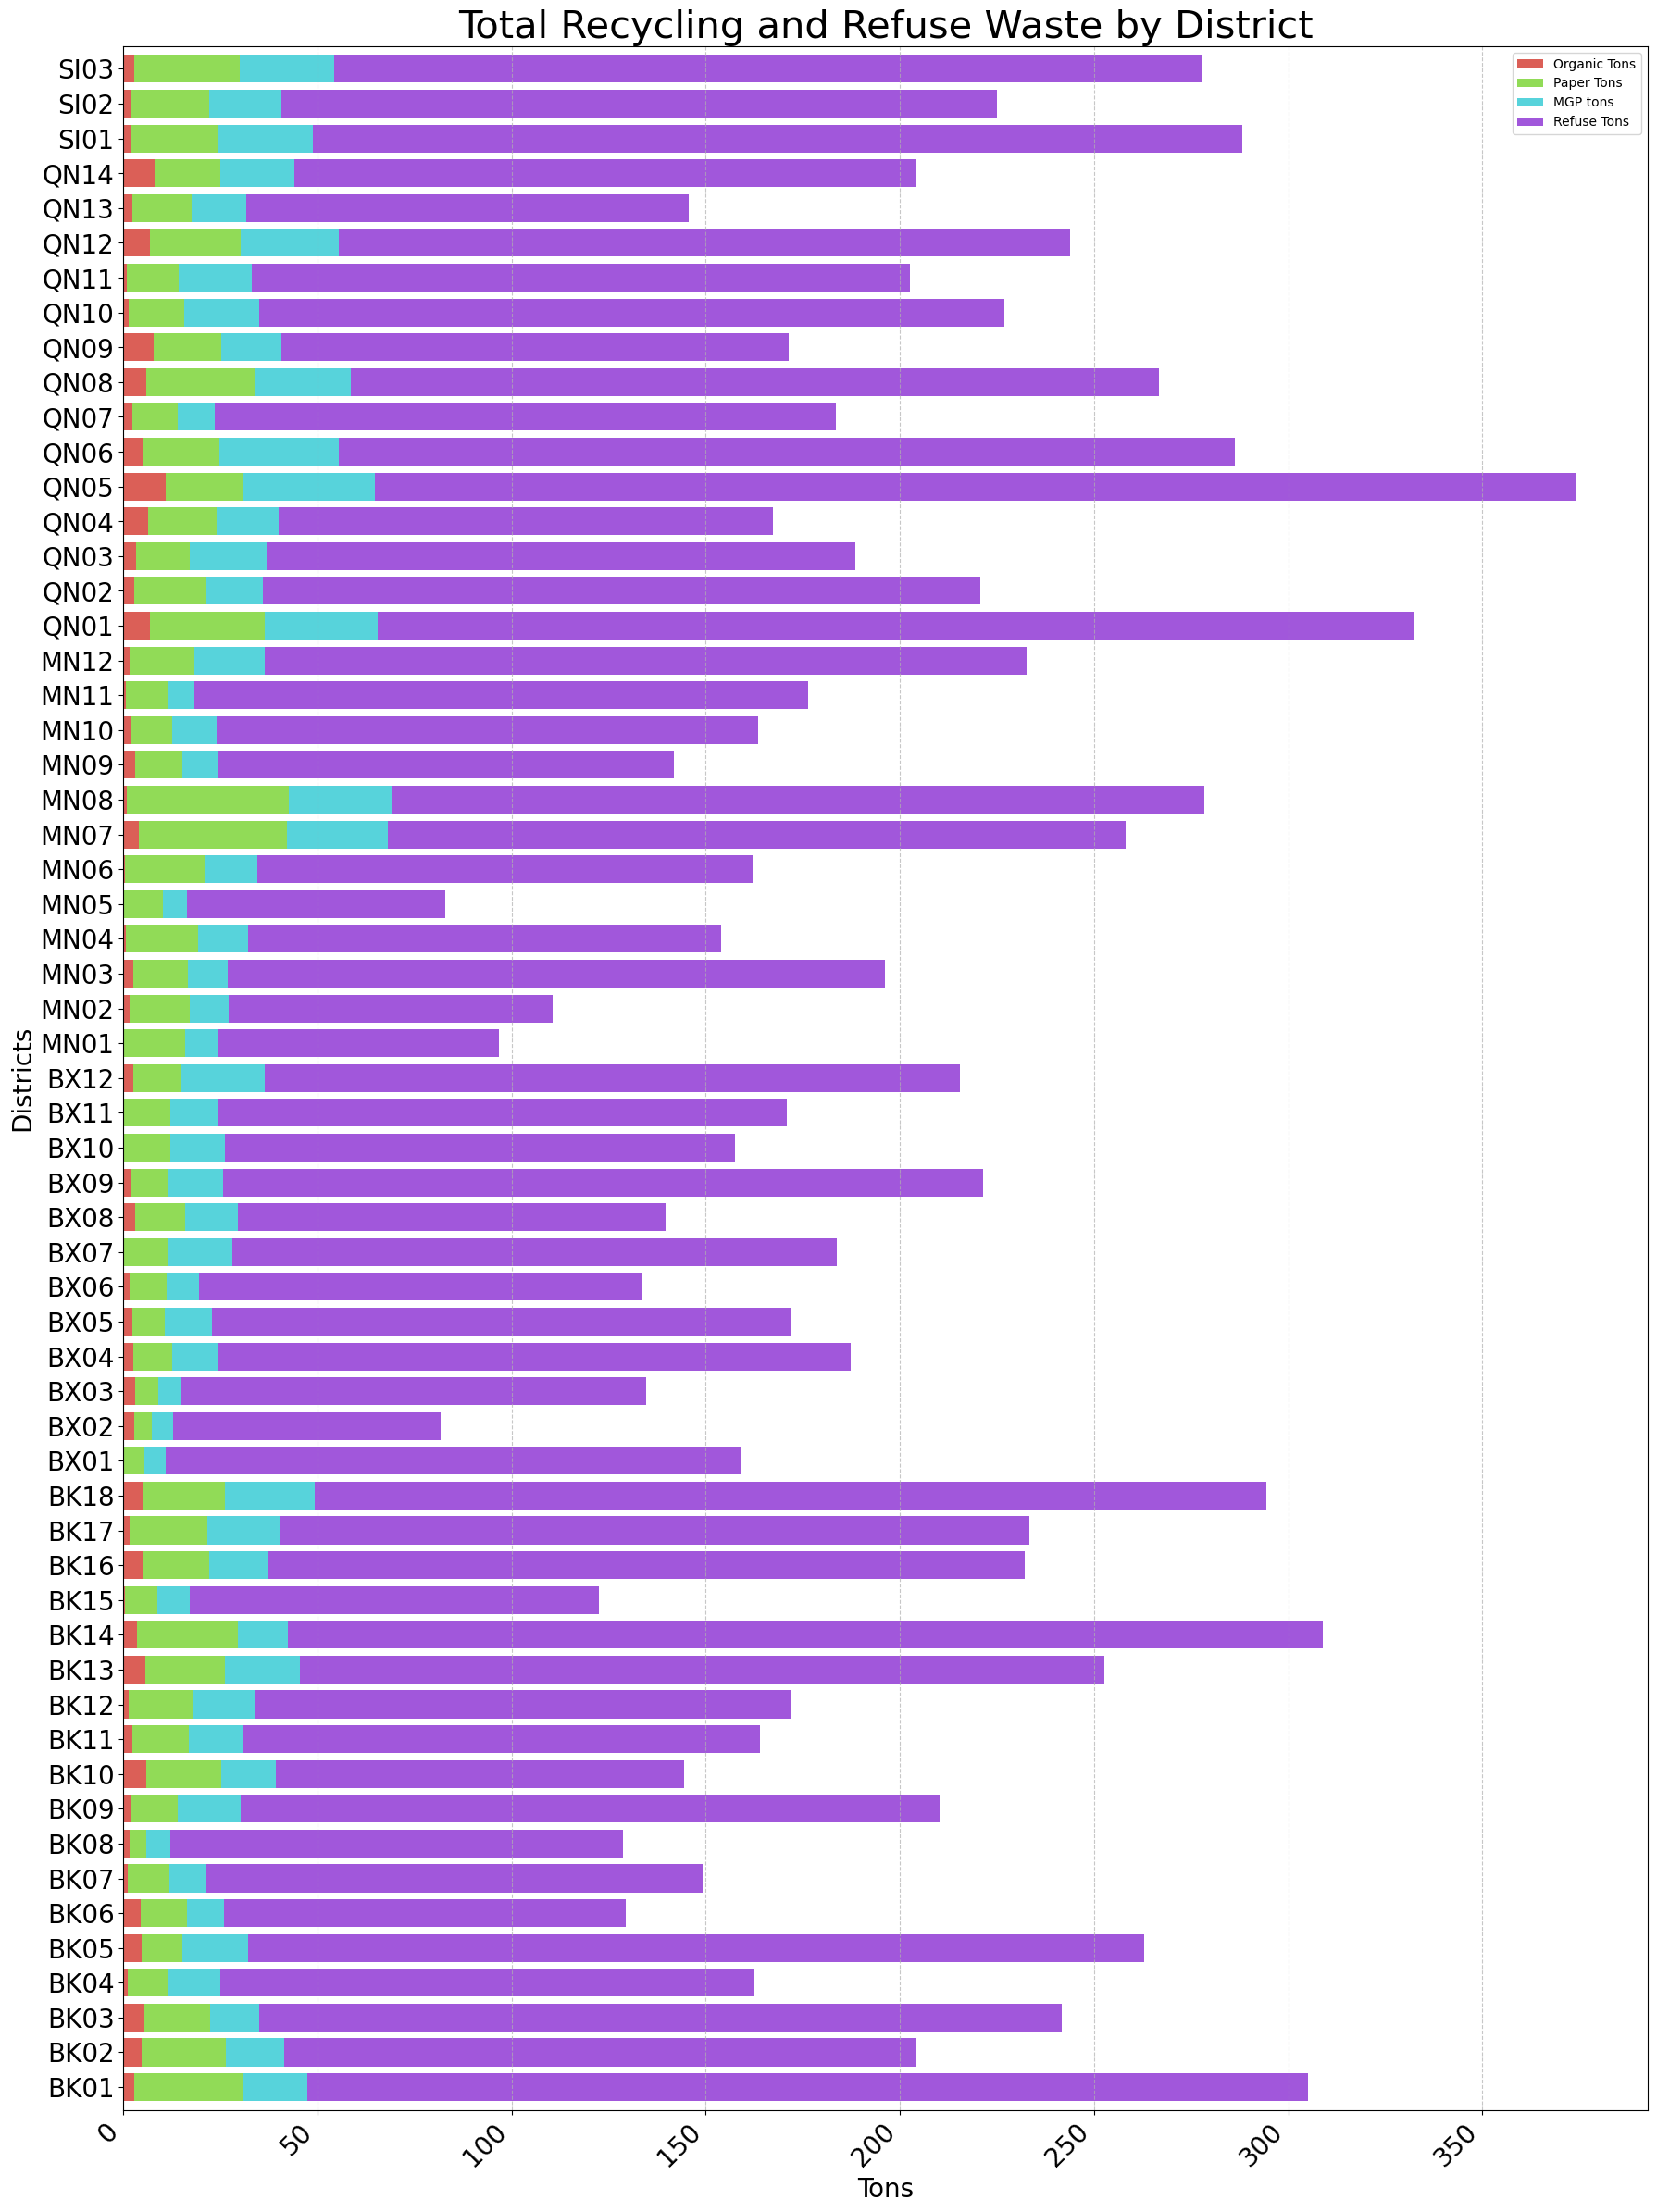

In [80]:
pastel_colors = sns.color_palette("hls", n_colors=4)

plt.figure(figsize=(18, 14))  # Further increased size of the chart

# Plot the bar chart with increased bar thickness and pastel colors
ax = df.groupby('District')[['Organic Tons', 'Paper Tons', 'MGP tons', 'Refuse Tons']].sum().plot(
    kind='barh', 
    stacked=True, 
    width=0.8,  # Thinner bars
    figsize=(18, 24),  # Increase figure size for better space
    color=pastel_colors  # Apply pastel colors
)
plt.yticks(fontsize=20)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=20)

# Add titles and labels
plt.title('Total Recycling and Refuse Waste by District', fontsize=30)
plt.ylabel('Districts', fontsize=20)
plt.xlabel('Tons', fontsize=20)

# Optional: Add gridlines for easier reading of bar values
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()  # Ensure everything fits nicely
plt.savefig('waste by district.png', bbox_inches="tight")
plt.show()

And what does this look like per person? Is trash generated and recyled uniformyl by everyone?

<Figure size 1800x1400 with 0 Axes>

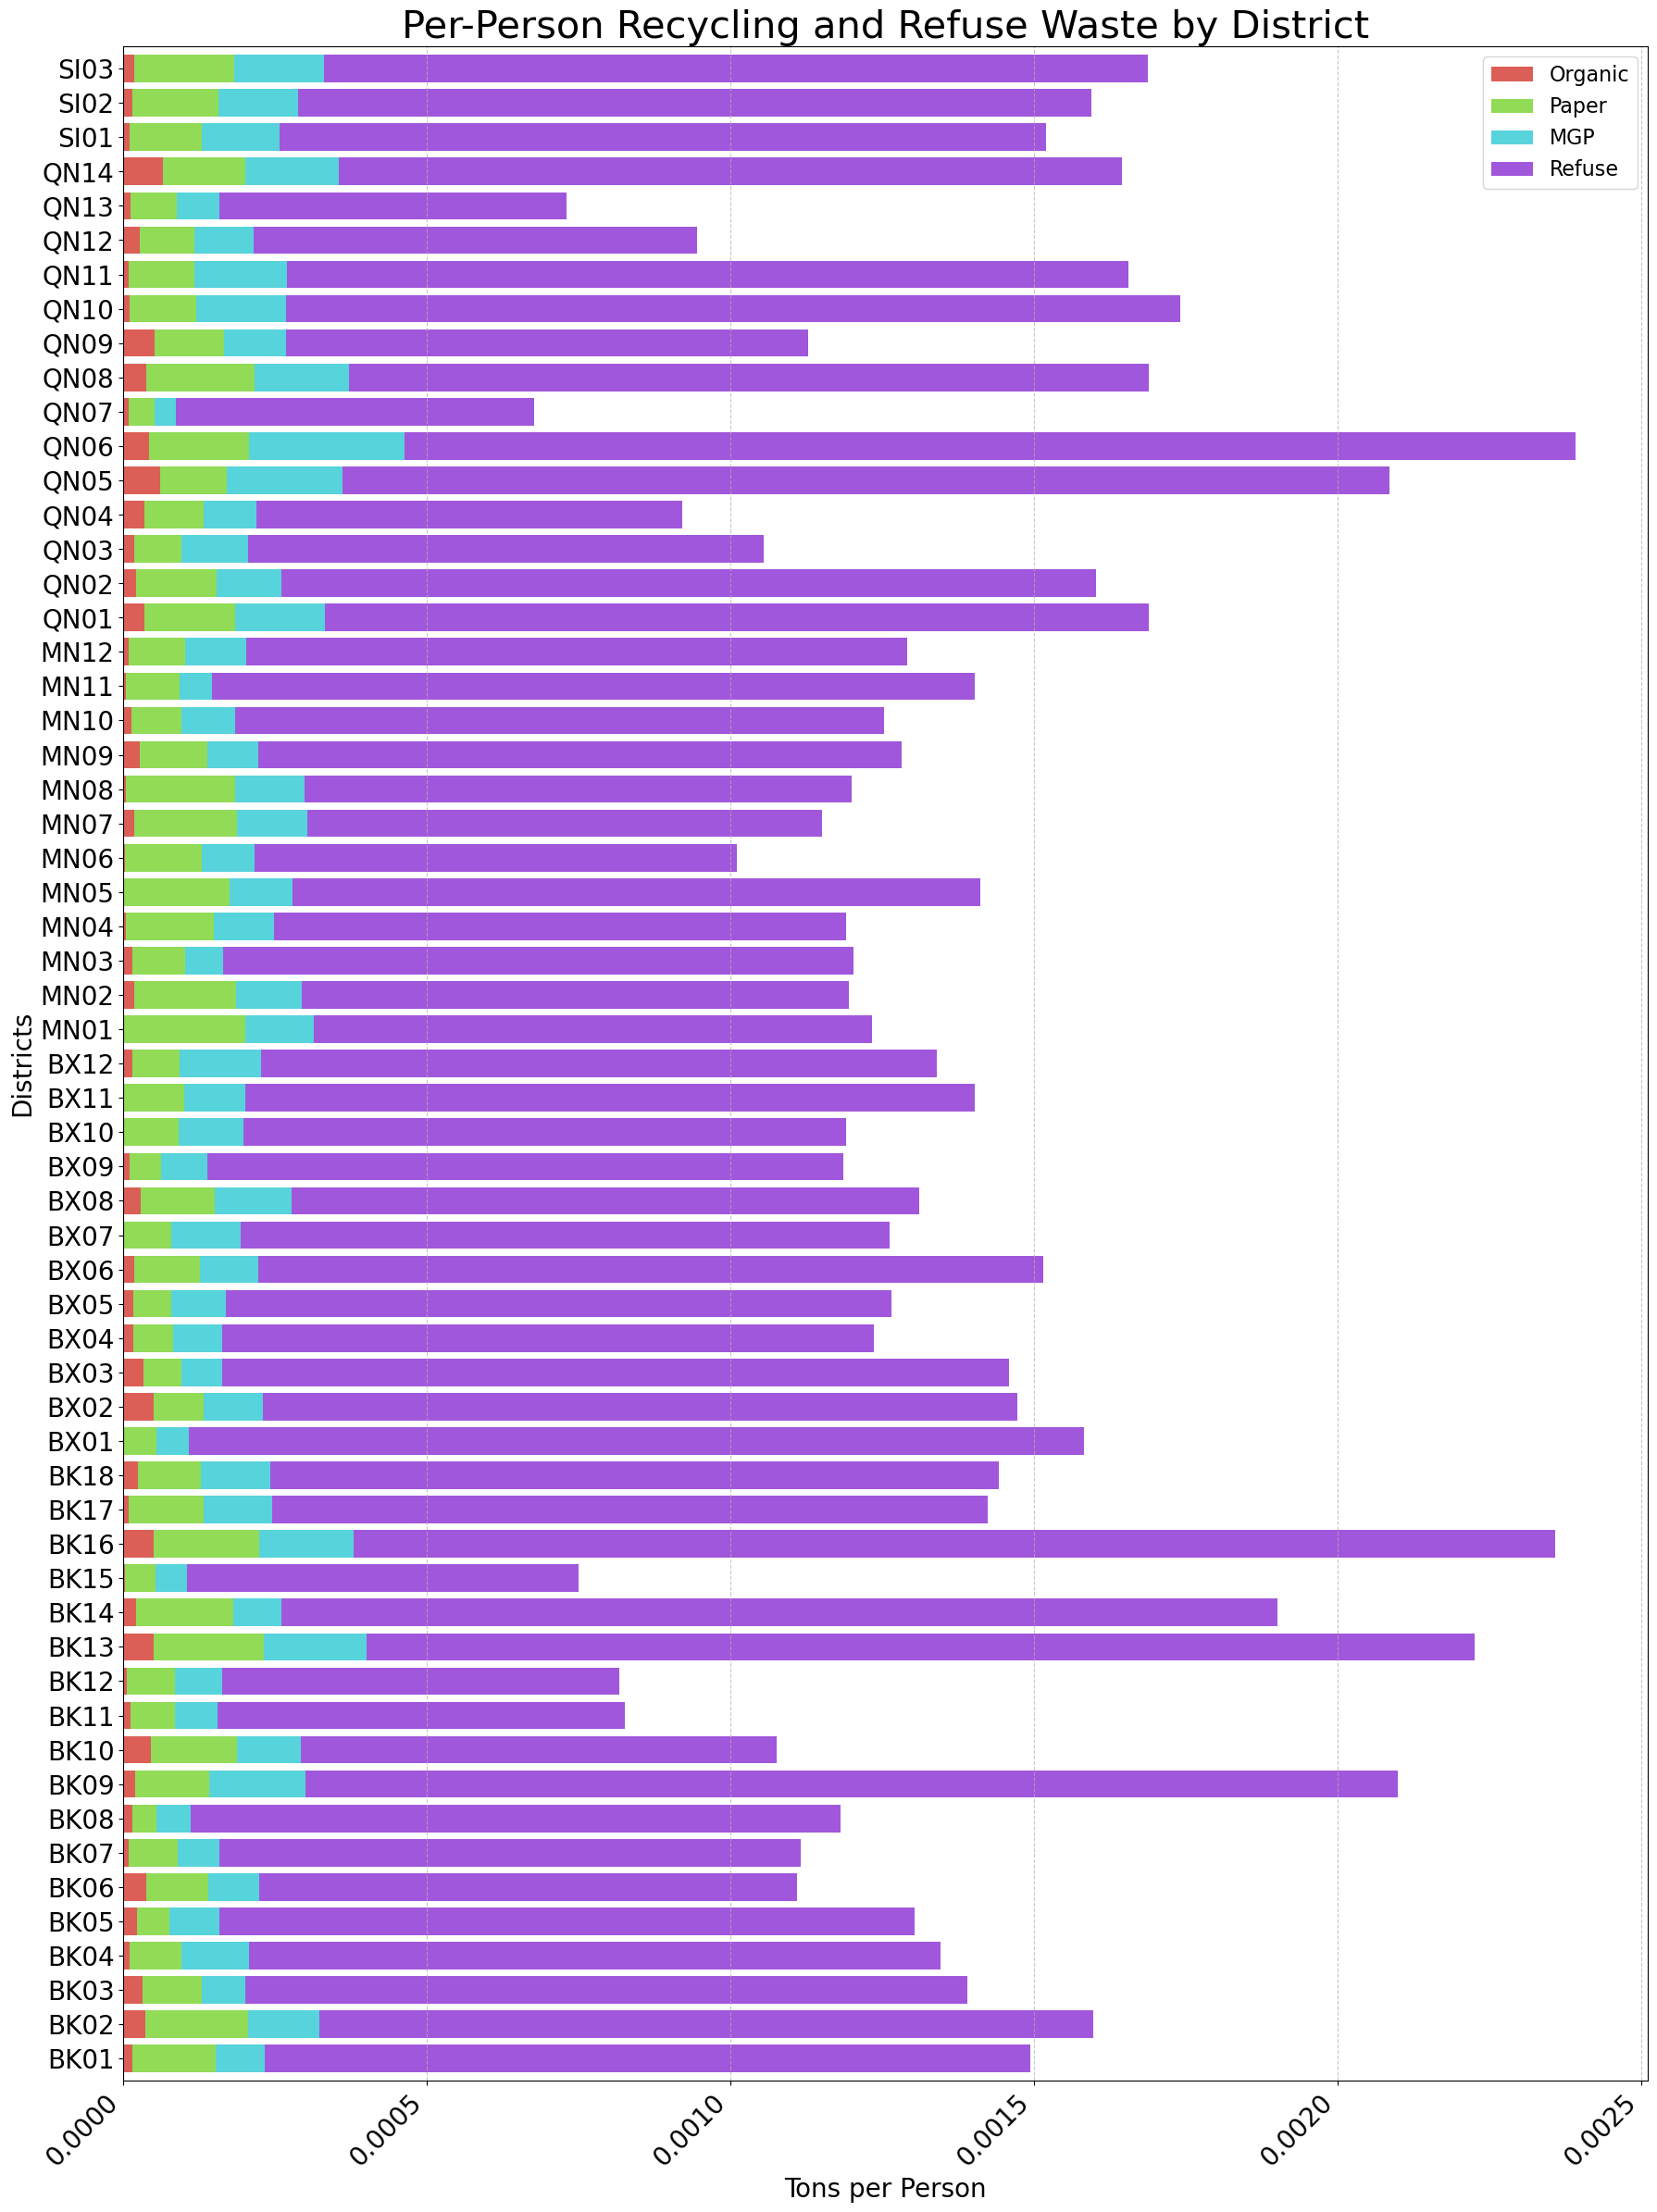

In [81]:
df_per_person = df.copy()

# Calculate per-person values (tons per person)
waste_columns = ['Organic Tons', 'Paper Tons', 'MGP tons', 'Refuse Tons']
for col in waste_columns:
    df_per_person[f'{col} per Person'] = df_per_person[col] / df_per_person['Total Population']

# Set up the plot
pastel_colors = sns.color_palette("hls", n_colors=4)
plt.figure(figsize=(18, 14))

# Group by district and sum the per-person values, then plot
per_person_columns = [f'{col} per Person' for col in waste_columns]
ax = df_per_person.groupby('District')[per_person_columns].sum().plot(
    kind='barh', 
    stacked=True, 
    width=0.8,
    figsize=(18, 24),
    color=pastel_colors
)

# Customize the plot
plt.yticks(fontsize=20)
plt.xticks(rotation=45, ha='right', fontsize=20)

# Add titles and labels
plt.title('Per-Person Recycling and Refuse Waste by District', fontsize=30)
plt.ylabel('Districts', fontsize=20)
plt.xlabel('Tons per Person', fontsize=20)

# Update legend to remove "per Person" suffix for cleaner look
legend_labels = ['Organic', 'Paper', 'MGP', 'Refuse']
plt.legend(legend_labels, fontsize=16, loc='best')

# Add gridlines for easier reading
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

# Ensure everything fits nicely
plt.tight_layout()

# Save and show the plot
plt.savefig('waste_per_person_by_district.png', bbox_inches="tight")
plt.show()

<Figure size 1800x1400 with 0 Axes>

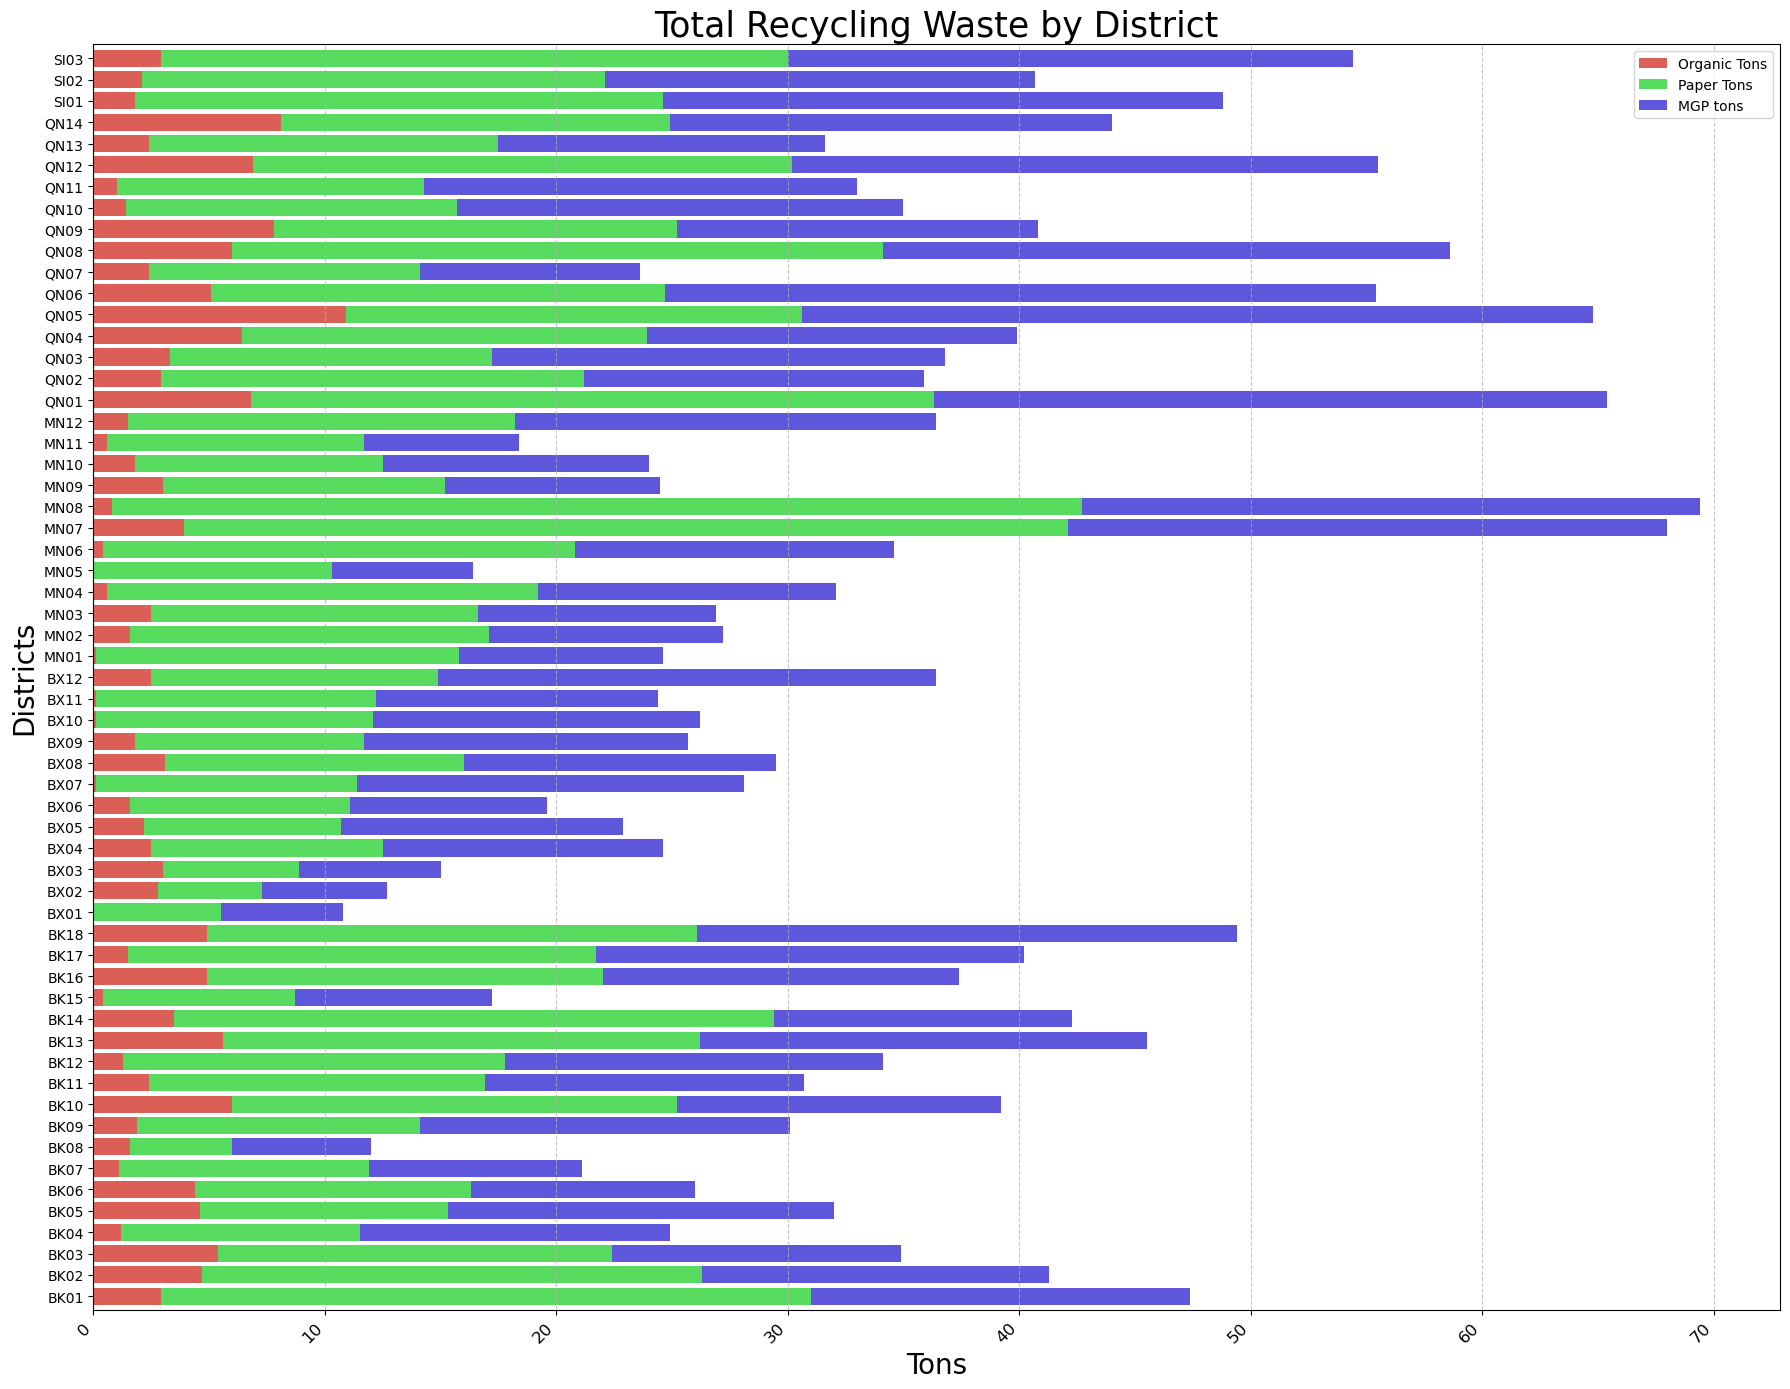

In [62]:
pastel_colors = sns.color_palette("hls", n_colors=3)

plt.figure(figsize=(18, 14))  # Further increased size of the chart

# Plot the bar chart with increased bar thickness and pastel colors
ax = df.groupby('District')[['Organic Tons', 'Paper Tons', 'MGP tons']].sum().plot(
    kind='barh', 
    stacked=True, 
    width=0.8,  # Thinner bars
    figsize=(18, 14),  # Increase figure size for better space
    color=pastel_colors  # Apply pastel colors
)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=12)

# Add titles and labels
plt.title('Total Recycling Waste by District', fontsize=25)
plt.ylabel('Districts', fontsize=20)
plt.xlabel('Tons', fontsize=20)

# Optional: Add gridlines for easier reading of bar values
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()  # Ensure everything fits nicely
plt.savefig('waste by district.png', bbox_inches="tight")
plt.show()

This data is for the tonnage. We can see tha parts of Queens and manhattan produce a lot of waste compared to the rest of the city. Interestingly, the organics in MN is very low despite the better preformance in other domains of recyling. It is not surprising that MN also has high paper tons recyling. This could be because of a lot of office apper that gets recyled? But how do these translate at the level of recylign percentages. 

<Figure size 1800x1400 with 0 Axes>

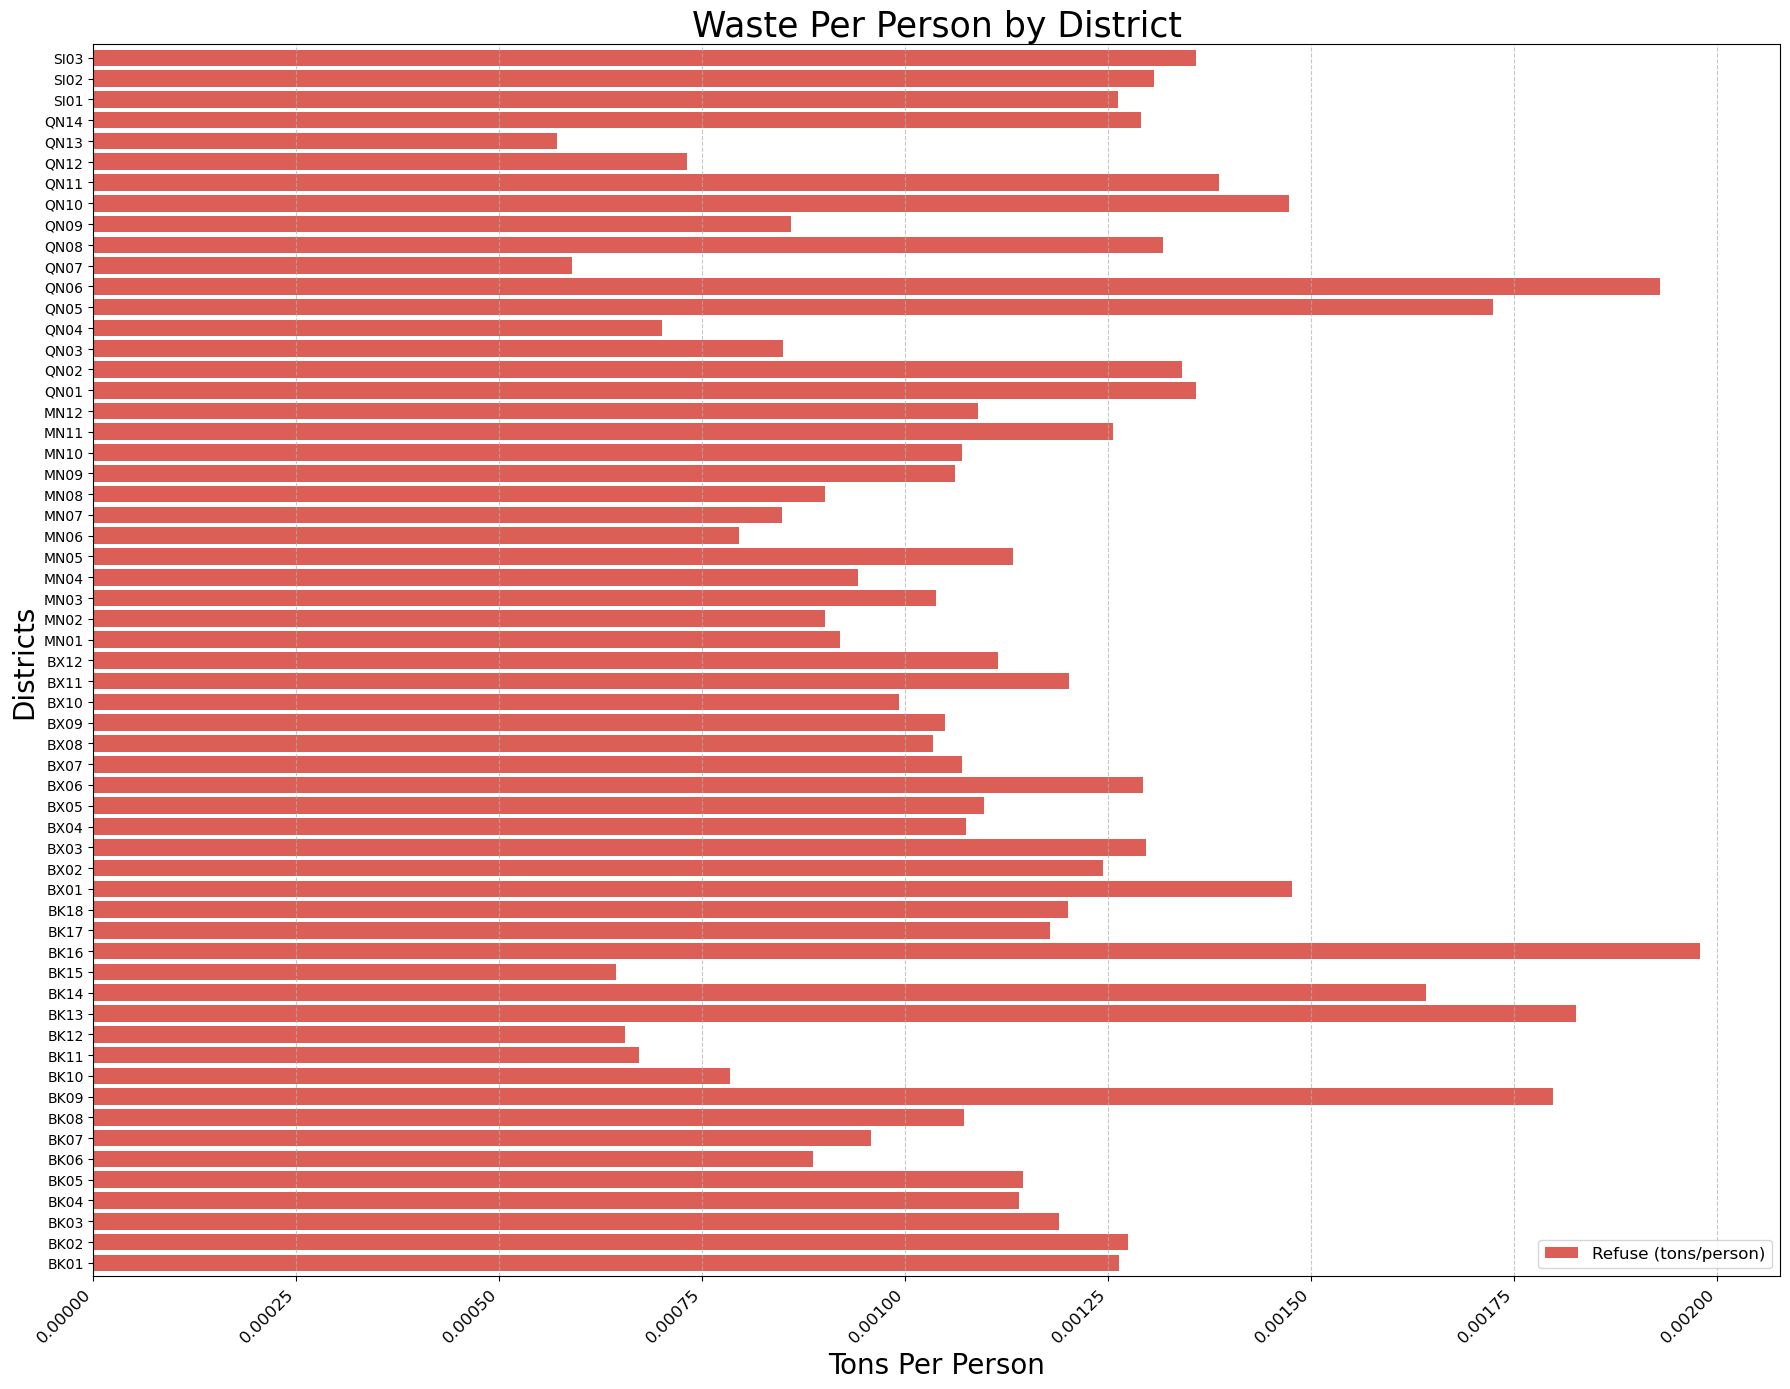


Waste Per Person by District:
   District  Organic Per Capita  Paper Per Capita  MGP Per Capita  \
0      BK01              0.0000            0.0001          0.0001   
1      BK02              0.0000            0.0002          0.0001   
2      BK03              0.0000            0.0001          0.0001   
3      BK04              0.0000            0.0001          0.0001   
4      BK05              0.0000            0.0001          0.0001   
5      BK06              0.0000            0.0001          0.0001   
6      BK07              0.0000            0.0001          0.0001   
7      BK08              0.0000            0.0000          0.0001   
8      BK09              0.0000            0.0001          0.0002   
9      BK10              0.0000            0.0001          0.0001   
10     BK11              0.0000            0.0001          0.0001   
11     BK12              0.0000            0.0001          0.0001   
12     BK13              0.0000            0.0002          0.0002   
13 

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# First, let's create per capita columns by dividing each waste type by Total Population
df_per_capita = df.groupby('District').agg({
    'Organic Tons': 'sum',
    'Paper Tons': 'sum', 
    'MGP tons': 'sum',
    'Refuse Tons': 'sum',
    'Total Population': 'first'  # Assuming population is the same for each district entry
}).reset_index()

# Calculate per capita values (tons per person)
df_per_capita['Organic Per Capita'] = df_per_capita['Organic Tons'] / df_per_capita['Total Population']
df_per_capita['Paper Per Capita'] = df_per_capita['Paper Tons'] / df_per_capita['Total Population']
df_per_capita['MGP Per Capita'] = df_per_capita['MGP tons'] / df_per_capita['Total Population']
df_per_capita['Refuse Per Capita'] = df_per_capita['Refuse Tons'] / df_per_capita['Total Population']

# Set up the plot
pastel_colors = sns.color_palette("hls", n_colors=4)
plt.figure(figsize=(18, 14))

# Create the bar chart with per capita data
ax = df_per_capita.set_index('District')[['Refuse Per Capita']].plot(
    kind='barh', 
    stacked=True, 
    width=0.8,
    figsize=(18, 14),
    color=pastel_colors
)

# Formatting
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.title('Waste Per Person by District', fontsize=25)
plt.ylabel('Districts', fontsize=20)
plt.xlabel('Tons Per Person', fontsize=20)

# Add gridlines for easier reading
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

# Update legend to reflect per capita units
plt.legend(['Refuse (tons/person)'], 
          loc='lower right', fontsize=12)

# Save and show
plt.tight_layout()
plt.savefig('waste_per_person_by_district.png', bbox_inches="tight")
plt.show()

# Optional: Display the per capita data table
print("\nWaste Per Person by District:")
print(df_per_capita[['District', 'Organic Per Capita', 'Paper Per Capita', 'MGP Per Capita', 'Refuse Per Capita']].round(4))

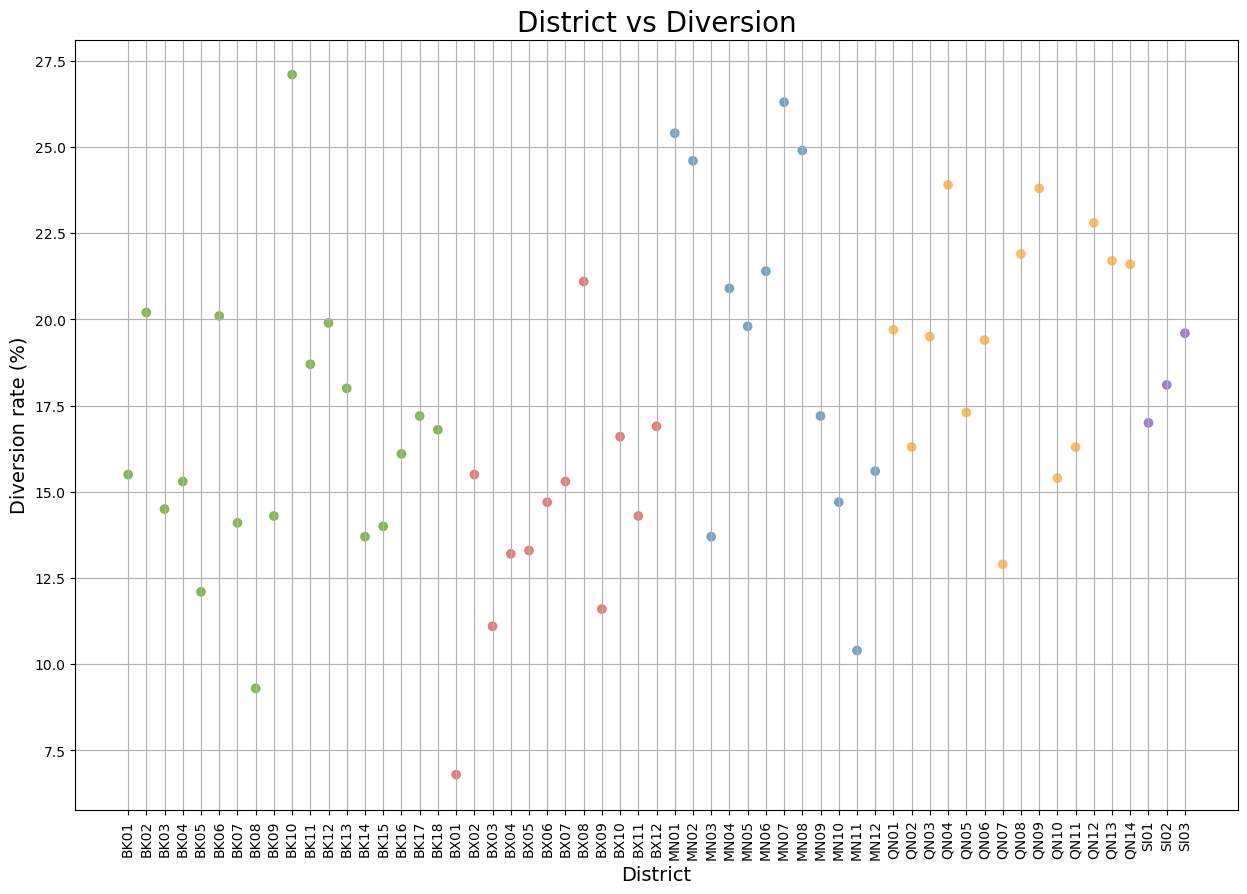

In [63]:
df['Borough'] = df['District'].str[:2]

color_map = {
    'MN': '#6D9EC1',  # Darker pastel blue for Manhattan
    'BK': '#7CB342',  # Darker pastel green for Brooklyn
    'BX': '#E57373',  # Darker pastel red for Bronx
    'QN': '#FFB74D',   # Darker pastel orange for Queens
    'SI': '#9575CD',  # Darker pastel purple for Staten Island
}

# Assign colors based on the borough
df['Color'] = df['Borough'].map(color_map)

# Sort df by district (to plot in order)
df = df.sort_values(by='District')

# Plot
plt.figure(figsize=(15,10))

# Scatter plot for each district, colored by borough
plt.scatter(df["District"], df["Diversion rate (%)"], 
            color=df["Color"], marker="o", alpha=0.9)

# Labels and Title
plt.xlabel("District", fontsize=14)
plt.ylabel("Diversion rate (%)", fontsize=14)
plt.title("District vs Diversion", fontsize=20)
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)
plt.savefig('Diversion_by_district.png',bbox_inches='tight')
# Show the plot
plt.show()

The above shows where the diverison rates lie per distrcit. Recall that we define:

Diversion rate is the percentage of all waste that is diverted away from disposal through recycling, composting, or other beneficial use. The diversion rate applies to the aggregate waste stream and is not applicable to individual materials.

Capture rate measures recyclable materials that are properly recycled in their respective recycling streams as a percentage of the total aggregate of that material across all streams. “Uncaptured material” refers to recyclable materials that are improperly disposed.

Let see what the diverison and capture rates look like on the map of NYC. 

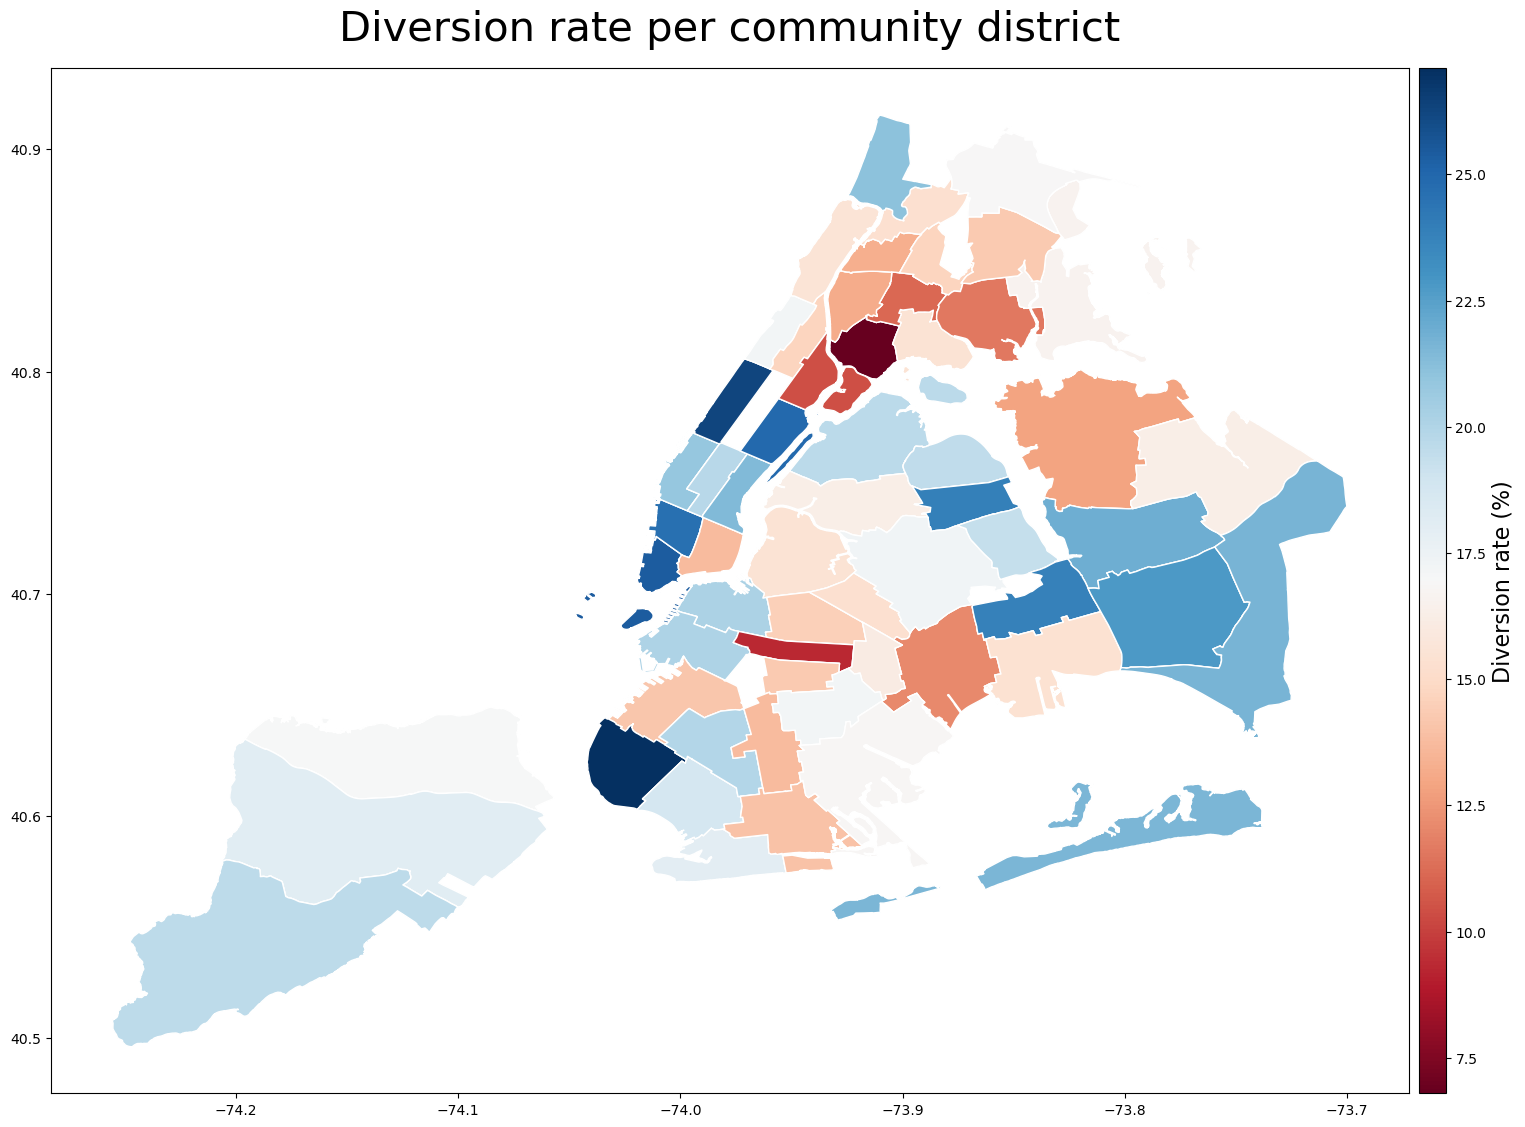

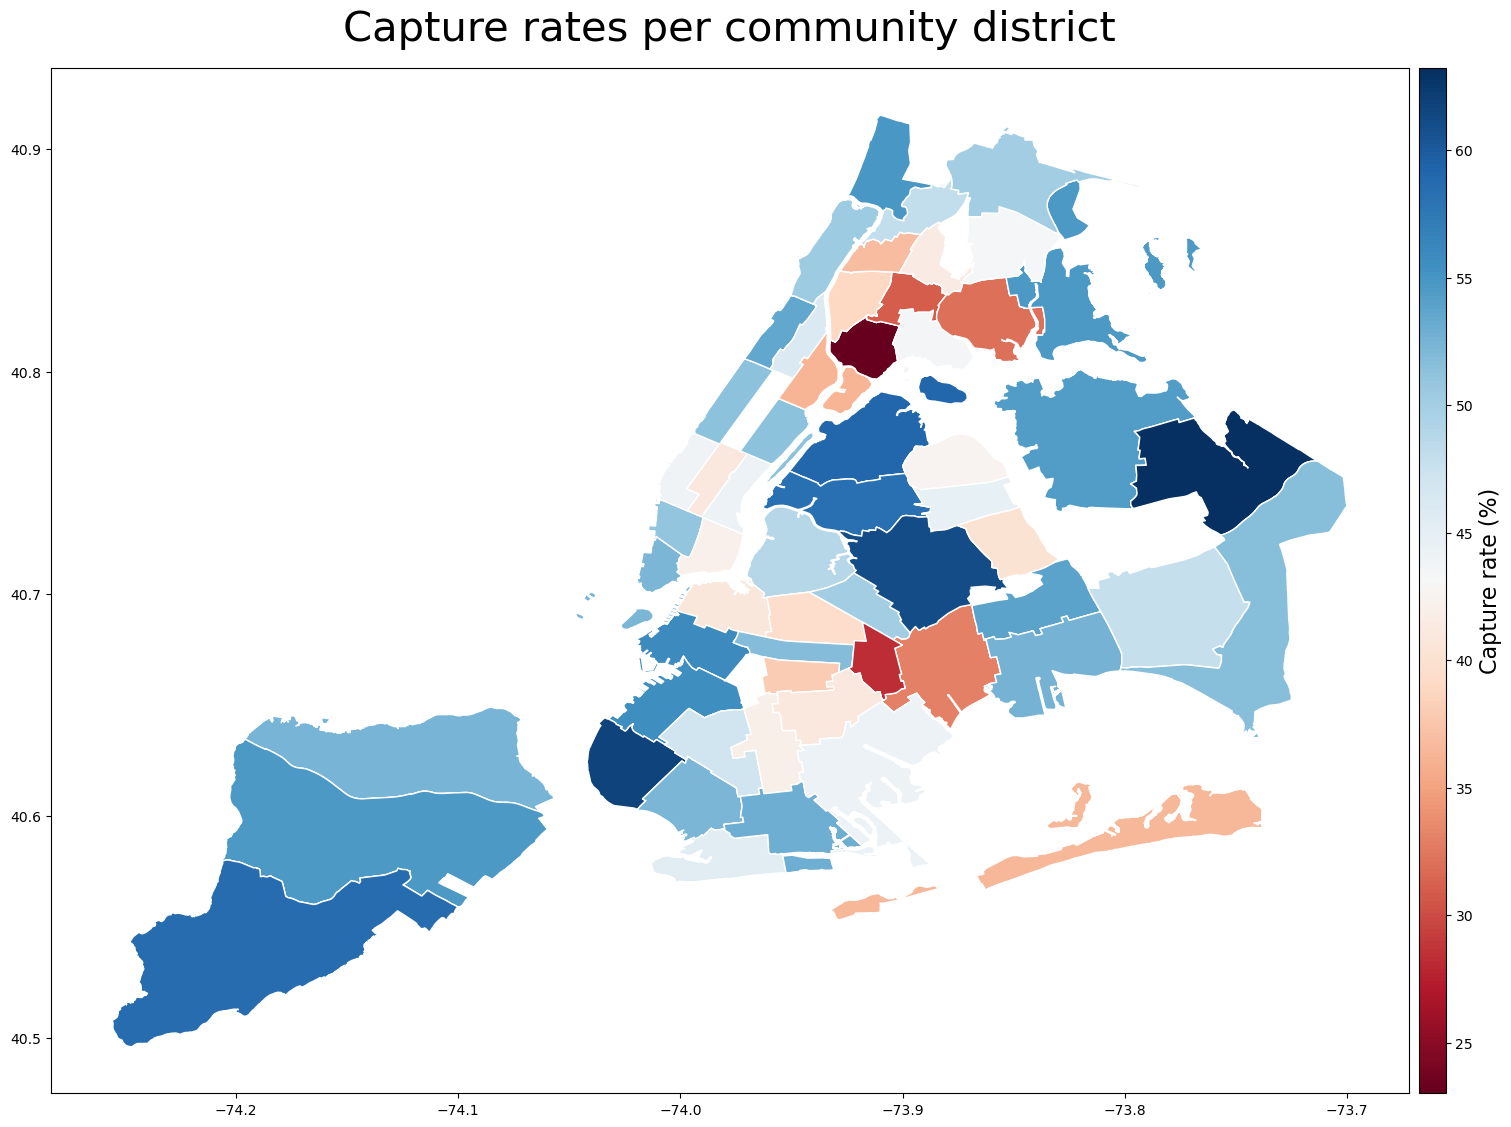

In [65]:
fig, ax = plt.subplots(figsize=(18, 26))

# Plot the map without the legend first and get the mappable object for the colorbar
mappable = merged_gdf.plot(
    column="Diversion rate (%)", 
    cmap="RdBu", 
    legend=False,  # No legend initially
    edgecolor="white",
    ax=ax
)

# Find the collections that were created by the plot
mappable = ax.get_children()[0]  # This should be the PathCollection with the colormap

# Keep the map's natural aspect ratio
ax.set_aspect('equal')

# Create a divider for the existing axes to place colorbar
divider = make_axes_locatable(ax)

# Append axes to the right of the main axes, with 2% width of the main axes
cax = divider.append_axes("right", size="2%", pad=0.1)

# Create colorbar in the appended axes
cbar = plt.colorbar(mappable, cax=cax)
cbar.set_label("Diversion rate (%)", size=16)

# Add title with padding
ax.set_title("Diversion rate per community district", fontsize=30, pad=20)

# Save with tight bbox
plt.savefig("district_wise_diversion_rate.png", dpi=300, bbox_inches='tight')
plt.show()


# Create figure with portrait dimensions
fig, ax = plt.subplots(figsize=(18, 26))

# Plot the map without the legend first and get the mappable object for the colorbar
mappable = merged_gdf.plot(
    column="Capture rates total (2019)", 
    cmap="RdBu", 
    legend=False,  # No legend initially
    edgecolor="white",
    ax=ax
)

mappable = ax.get_children()[0]  # This should be the PathCollection with the colormap

# Keep the map's natural aspect ratio
ax.set_aspect('equal')

# Create a divider for the existing axes to place colorbar
divider = make_axes_locatable(ax)

# Append axes to the right of the main axes, with 2% width of the main axes
cax = divider.append_axes("right", size="2%", pad=0.1)

# Create colorbar in the appended axes
cbar = plt.colorbar(mappable, cax=cax)
cbar.set_label("Capture rate (%)", size=16)

# Add title with padding
ax.set_title("Capture rates per community district", fontsize=30, pad=20)

# Save with tight bbox
plt.savefig("district_wise_capture_rate.png",dpi=300,bbox_inches='tight')
plt.show()